
# ATSC PBIL: Pipeline Notebook

Notebook này chạy tuần tự các bước:
1) Build **net-info file** và **tls-candidates** → `net-info.json`, `tls-candidates.json`
2) **Chạy baselines** (No-ATSC / All-ATSC)  
3) **Chạy thuật toán lựa chọn nút giao** (PBIL)
4) **Chạy đánh giá kết quả** (Evaluate)
5) **Tổng hợp & trực quan hoá** kết quả

> Gợi ý: đặt file này vào thư mục `scripts/` của repo: `scripts/atsc_pipeline.ipynb`.

### 0. Setup Environment

In [2]:
# Install dependencies
# !poetry install
# Import libraries dependencies
import subprocess
import json
import os
from IPython.display import Image, display
from datetime import datetime

In [8]:
# Setup path run
PROJECT_ROOT = "E:/VTS/ITS/Choose ATSC/Software/choose_ATSC_PBIL"
%cd {PROJECT_ROOT}

# Setup path for SUMO
SUMO_HOME = os.environ.get('SUMO_HOME', '/usr/share/sumo')

# Setup config file
CONFIG_FILE = os.path.join(PROJECT_ROOT, "configs", "config.json")

# Setup run dir:
RUN_DIR = "data/results/runs/2025-08-20_14-04-42"

# ------------------ DO NOT MODIFY ------------------

# If not setup run dir
if not RUN_DIR:
    RUN_DIR = os.path.join("data", "results", "runs", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Print detail
print(f"Project root: {PROJECT_ROOT}")
print(f"SUMO home: {SUMO_HOME}")
print(f"Run dir: {RUN_DIR}")

# Load Config
with open(CONFIG_FILE, "r") as f:
    config = json.load(f)


E:\VTS\ITS\Choose ATSC\Software\choose_ATSC_PBIL
Project root: E:/VTS/ITS/Choose ATSC/Software/choose_ATSC_PBIL
SUMO home: C:\Program Files (x86)\Eclipse\Sumo\
Run dir: data/results/runs/2025-08-20_14-04-42


In [4]:
# Function for running a command
def run_command(cmd):
    """
    Chạy một command (list hoặc string) và stream output ra stdout theo thời gian thực.
    
    Args:
        cmd (list[str] | str): lệnh cần chạy, ví dụ:
            ["poetry", "run", "run-baselines", "--config", "configs/config.json"]
            hoặc "poetry run run-baselines --config configs/config.json"
    """
    if isinstance(cmd, str):
        shell = True
    else:
        shell = False

    process = subprocess.Popen(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        encoding="utf-8",
        errors="replace",
        bufsize=1,
        shell=shell
    )

    for line in process.stdout:
        print(line, end="")  # stream ngay
    process.wait()
    return process.returncode


### 1. Build net-info and tls-candidate files

Sinh `net-info.json` (No-ATSC / All-ATSC).

In [8]:
# ============ Build net-info ============
run_command(["poetry", "run", "build-net-info", "--net", config['sumo']['net_file'], "--detectors", config['sumo']['detectors_file'], "--out", config['sumo']['net_info_file']])

✅ Đã tạo: data/input/sumo/PhuQuoc_v2/net-info.json


0

Sinh `tls-candidates.json`

In [9]:
# ============ Build tls-candidates ============
run_command(["poetry", "run", "build-tls-candidates", "--net", config["sumo"]["net_file"], "--out", config["sumo"]["candidates_file"]])

✅ Đã tạo:  data/input/sumo/PhuQuoc_v2/tls-candidates.json


0

### 2. Run PBIL Algorithm

Chạy `run_pbil.py` để sinh ra các file kết quả cho thuật toán PBIL.

In [ ]:
# ============= Run PBIL Algorithm =============
run_command(["poetry", "run", "run-custom", "--config", "configs/config.json", "--output", RUN_DIR])

### 3. Evaluation Baseline and PBIL Results

Chạy `evaluate.py` để đánh giá kết quả của các thuật toán (all-ATSC, no-ATSC, PBIL)

In [20]:
# ============= RUN EVALUATION =============
BEST_CONFIG_FILE = os.path.join(RUN_DIR, "pbil", "best_configs.json")
run_command(["poetry", "run", "evaluation", "--config", CONFIG_FILE, "--output", RUN_DIR, "--best", BEST_CONFIG_FILE])

2025-08-20 15:47:43 [INFO] ========== Starting Evaluation ==========
2025-08-20 15:47:43 [INFO] Loaded configuration from: E:/VTS/ITS/Choose ATSC/Software/choose_ATSC_PBIL\configs\config.json
2025-08-20 15:47:43 [INFO] Loaded network information from: data/input/sumo/PhuQuoc_v2/net-info.json
2025-08-20 15:47:43 [INFO] Setting up run directory: data/results/runs/2025-08-20_14-04-42/evaluation
2025-08-20 15:47:43 [INFO] Starting parallel evaluation processes...
2025-08-20 16:02:35 [INFO] Baseline 1 completed successfully
2025-08-20 16:02:35 [INFO] Baseline 2 completed successfully
2025-08-20 16:02:35 [INFO] PBIL ATSC completed successfully
2025-08-20 16:02:35 [INFO] All evaluations saved to: data/results/runs/2025-08-20_14-04-42/evaluation
2025-08-20 16:02:35 [INFO] ========== Evaluations Completed ==========


0

### 4. Visualization


#### 4.0 Import thư viện cần thiết

In [ ]:
import json
import pandas as pd

#### 4.1 Bảng so sánh kết quả `pbil_results.csv`


In [ ]:
# Params — Sửa 3 biến này cho phù hợp
scores_path = "/content/scores_history.json"      # path tới scores_history.json
tls_candidates_path = "/content/tls-candidates.json"  # path tới tls-candidates.json
N = 10  # Hiển thị bao nhiêu hàng

# Đọc file
with open(tls_candidates_path, "r", encoding="utf-8") as f:
    tls_data = json.load(f)

with open(scores_path, "r", encoding="utf-8") as f:
    scores_history = json.load(f)

# Lấy danh sách tiêu đề cột từ tls-candidates (giữ nguyên thứ tự khóa trong file)
candidate_ids = list(tls_data["candidate_tls_ids"].keys())

# Chuyển đổi dữ liệu scores_history -> DataFrame
# Mỗi phần tử có dạng [atsc_array, score]
rows = []
for item in scores_history:
    atsc_array, score = item
    # Bảo vệ: nếu độ dài mảng chưa khớp số cột, cắt hoặc đệm 0 cho khớp
    if len(atsc_array) < len(candidate_ids):
        atsc_array = atsc_array + [0] * (len(candidate_ids) - len(atsc_array))
    elif len(atsc_array) > len(candidate_ids):
        atsc_array = atsc_array[: len(candidate_ids)]

    row = {cid: val for cid, val in zip(candidate_ids, atsc_array)}
    row["Total ATSC"] = sum(atsc_array)
    row["Score"] = float(score)
    rows.append(row)

df = pd.DataFrame(rows, columns=candidate_ids + ["Total ATSC", "Score"])

# Sắp xếp theo Score tăng dần và hiển thị N hàng
df_sorted = df.sort_values(by="Score", ascending=True, kind="mergesort").reset_index(drop=True)
display(df_sorted.head(N))

output_path = "/content/scores_sorted.csv"
df_sorted.to_csv(output_path, index=False, encoding="utf-8")

print(f"Đã xuất ra file: {output_path}")


Figure(640x480)


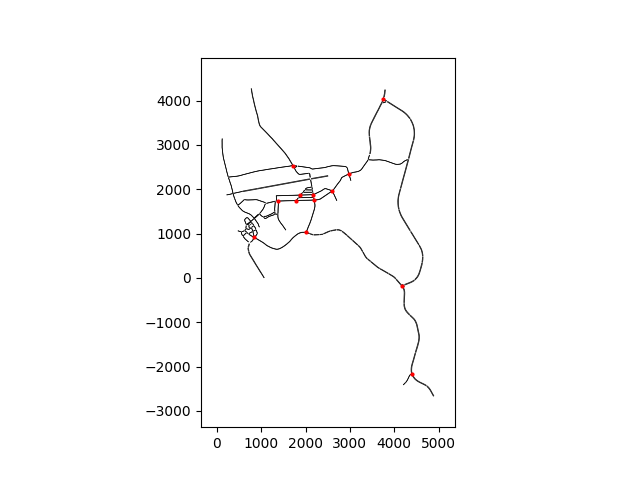

In [17]:
randomTrip = os.path.join(SUMO_HOME, 'tools', 'visualization', 'plot_net_trafficLights.py')
filename = os.path.join(RUN_DIR, 'ATSC_map.png')
run_command(["poetry", "run", "python", randomTrip, '-n', 'data/input/sumo/PhuQuoc_v2/phuquoc.net.xml', '--edge-width', '.5', '--width', '2', '-o', filename])
display(Image(filename=filename))

idattr 'id' not found in data/results/runs/2025-08-20_14-04-42/evaluation/output_all_atsc_summary-output.xml
Figure(1400x900)


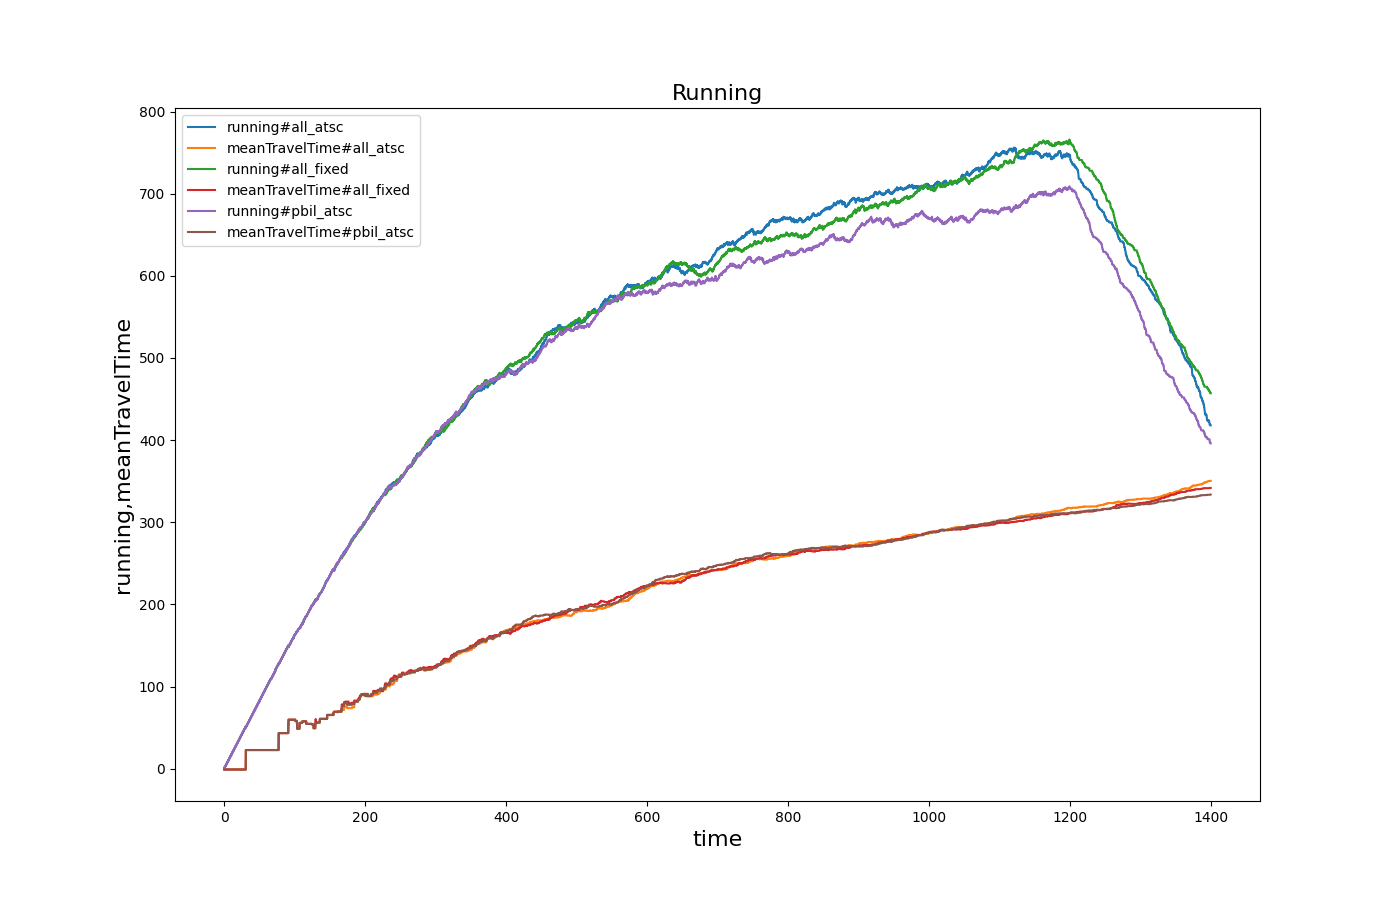

In [30]:
plotXMLAttributes = os.path.join(SUMO_HOME, 'tools', 'visualization', 'plotXMLAttributes.py')
filename = 'ATSC_map.png'
run_command(["poetry", "run", "python", plotXMLAttributes, 'data/results/runs/2025-08-20_14-04-42/evaluation/output_all_atsc_summary-output.xml', 'data/results/runs/2025-08-20_14-04-42/evaluation/output_all_fixed_summary-output.xml', 'data/results/runs/2025-08-20_14-04-42/evaluation/output_pbil_atsc_summary-output.xml', '--title', 'Running', '--legend' , '-x', 'time', '-y', 'running,meanTravelTime', '-o', filename])
display(Image(filename=filename))

### 3) Visualize Results

Installing dependencies from lock file

No dependencies to install or update

Installing the current project: choose-atsc-pbil (0.1.0)


In [ ]:
# Run NO-ATSC baseline
!poetry run run-custom --config "$path_folder/configs/configs.json" --net_info "$path_folder/net_info.json"

: 